In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import pynwb
import glob
import os
from pathlib import Path 

from sklearn.cluster import KMeans
from numpy import linalg as LA
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy import stats
from scipy import optimize
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import average_precision_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import r2_score
from scipy.optimize import curve_fit
from scipy.optimize import differential_evolution
from scipy.stats import ttest_rel
from scipy.stats import norm
from scipy.stats import f
from scipy.stats import chi2
from scipy import signal
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.formula.api import ols
import matplotlib
from sklearn.metrics import confusion_matrix
import matplotlib.gridspec as gridspec
import joblib
import pickle
from sklearn import linear_model
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from statsmodels.tools.tools import add_constant

# load custom functions
import load_data
import graph

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
sz1 = 12
sz2 = 12
sns.set(style="ticks", rc={"lines.linewidth": 1})
matplotlib.rc('xtick', labelsize=sz1) 
matplotlib.rc('ytick', labelsize=sz1) 
matplotlib.rc('axes', labelsize=sz1)  
matplotlib.rc('axes', titlesize=sz1)  
matplotlib.rc('figure', titlesize=sz2)
matplotlib.rc('legend', fontsize=sz1) 
matplotlib.rc('legend', title_fontsize=sz1)
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False

In [10]:
def predict_value(df, FR, ntrials=1000, w=100, slide=50, kfold=10, random_state=42):
    
    """
    Optimized version of predict_value using StratifiedKFold and sklearn utilities.
    """
    
    # Precompute parameters
    timestamps = np.arange(w, 1000 - w + slide, slide)
    
    # Assign FR into dataframe
    df = df.copy()
    df['Neural'] = list(FR)
    df.loc[df.graph_distance > 2, 'graph_distance'] = 3
    
    # Stratified KFold for balanced splits across graph distances
    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    # Extract features and labels
    X = np.stack(df['Neural'].values)
    y = df['graph_distance'].values.astype(int)
    y_test_all = np.zeros(len(y))
    pred_value = np.ones((len(y),len(timestamps)))*np.nan
    
    # Model
    lasso_cv = make_pipeline(StandardScaler(),
        LassoCV(cv=5, random_state=random_state, n_alphas=100))
    
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        
        # Bootstrapped training set sampling
        train_boot_idx = np.random.choice(train_idx, size=ntrials, replace=True)
        
        X_train, y_train = X[train_boot_idx], y[train_boot_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # Store y_test for later correlation computation
        y_test_all[test_idx] = y_test
        
        
        for ti, t in enumerate(timestamps):
            
            # Average activity across window for each trial
            X_train_win = X_train[:, t - w:t + w, :].mean(axis=1)
            X_test_win = X_test[:, t - w:t + w, :].mean(axis=1)
            
            # Train LassoCV to predict graph distance

            if X_train_win.shape[1] == 0 or np.isnan(X_train_win).any() or np.isnan(y_train).any():
                continue
            if np.allclose(X_train_win.std(axis=0), 0):
                continue
            
            try:
                lasso_cv.fit(X_train_win, y_train)
                pred_value[test_idx,ti] = lasso_cv.predict(X_test_win)
            except ValueError as e:
                print(f"Skipping t={t}: {e}")
                continue
                  
    
    # Compute R^2 (squared correlation coefficient) over timestamps
    # rsquare = np.array([
    #     np.corrcoef(pred_value[t_idx, :], y_test_all)[0, 1] ** 2
    #     for t_idx in range(len(timestamps))
    # ])

    # rsquare = np.array([
    #     r2_score(pred_value[:, t_idx], y_test_all)
    #     for t_idx in range(len(timestamps))
    # ])


    return pred_value


In [24]:
def predict_value_add_noise(df, FR, ntrials=1000, w=100, slide=50, kfold=10, random_state=42,noise_level=10):
    
    """
    Optimized version of predict_value using StratifiedKFold and sklearn utilities.
    """
    
    # Precompute parameters
    timestamps = np.arange(w, 1000 - w + slide, slide)
    
    # Assign FR into dataframe
    df = df.copy()
    df['Neural'] = list(FR)
    df.loc[df.graph_distance > 2, 'graph_distance'] = 3
    
    # Stratified KFold for balanced splits across graph distances
    skf = StratifiedKFold(n_splits=kfold, shuffle=True, random_state=random_state)
    
    # Extract features and labels
    X = np.stack(df['Neural'].values)
    y = df['graph_distance'].values.astype(int)
    y_test_all = np.zeros(len(y))
    pred_value = np.ones((len(y),len(timestamps),noise_level))*np.nan
    
    # Model
    lasso_cv = make_pipeline(StandardScaler(),
        LassoCV(cv=5, random_state=random_state, n_alphas=100))
    
    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y)):
        
        # Bootstrapped training set sampling
        train_boot_idx = np.random.choice(train_idx, size=ntrials, replace=True)
        
        X_train, y_train = X[train_boot_idx], y[train_boot_idx]
        X_test, y_test = X[test_idx], y[test_idx]
        
        # Store y_test for later correlation computation
        y_test_all[test_idx] = y_test
        
        
        for ti, t in enumerate(timestamps):
            
            # Average activity across window for each trial
            X_train_win = X_train[:, t - w:t + w, :].mean(axis=1)
            X_test_win = X_test[:, t - w:t + w, :].mean(axis=1)
            
            # Train LassoCV to predict graph distance

            if X_train_win.shape[1] == 0 or np.isnan(X_train_win).any() or np.isnan(y_train).any():
                continue
            if np.allclose(X_train_win.std(axis=0), 0):
                continue
            
            try:
                lasso_cv.fit(X_train_win, y_train)
                # introduce 5 levels of gaussian noise into FR, predict values for each noise level
                for mm in range(noise_level):
                    pred_value[test_idx,ti,mm] = lasso_cv.predict(X_test_win + np.random.normal(loc=0.0, scale=X_test_win*0.2*mm))
            except ValueError as e:
                print(f"Skipping t={t}: {e}")
                continue
                  
    
    # Compute R^2 (squared correlation coefficient) over timestamps
    # rsquare = np.array([
    #     np.corrcoef(pred_value[t_idx, :], y_test_all)[0, 1] ** 2
    #     for t_idx in range(len(timestamps))
    # ])

    # rsquare = np.array([
    #     r2_score(pred_value[:, t_idx], y_test_all)
    #     for t_idx in range(len(timestamps))
    # ])


    return pred_value, y_test_all


In [102]:
ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}
all_sessions = pd.DataFrame(ses_info)  # London

generic_rsquare = np.zeros((2,len(all_sessions),17))
# specific_rsquare = np.zeros((2,len(all_sessions),4,17))

for ii in range(len(all_sessions)):

    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, session)

    DATA_DIR, FIG_DIR = load_data.initiate_directory(animal, session)

    for rr, region in enumerate(['HPC','OFC']):
    
        results = load_data.load_beh_neural(animal, session, region,'action_on','(trialerror==0)')
        spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
        
        if spikes.size!=0:
            generic_rsquare[rr,ii,:], decoder = predict_value(df.copy(), spikes.copy(),kfold=10)
    
        
        
        # results = load_data.load_beh_neural(animal, session, region,'action_on','(trialerror==0)&(target==1)')
        # spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
        
        # if spikes.size!=0:
        #     specific_rsquare[rr,ii,0,:], decoder = predict_value(df.copy(), spikes.copy(),kfold=10)
    
    
        # results = load_data.load_beh_neural(animal, session, region,'action_on','(trialerror==0)&(target==7)')
        # spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
        
        # if spikes.size!=0:
        #     specific_rsquare[rr,ii,1,:], decoder = predict_value(df.copy(), spikes.copy(),kfold=10)
    
    
        # results = load_data.load_beh_neural(animal, session, region,'action_on','(trialerror==0)&(target==8)')
        # spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
        
        # if spikes.size!=0:
        #     specific_rsquare[rr,ii,2,:], decoder = predict_value(df.copy(), spikes.copy(),kfold=10)
    
    
        # results = load_data.load_beh_neural(animal, session, region,'action_on','(trialerror==0)&(target==14)')
        # spikes, df, unitNames = results['spikes'], results['beh'], results['unitNames']
        
        # if spikes.size!=0:
        #     specific_rsquare[rr,ii,3,:], decoder = predict_value(df.copy(), spikes.copy(),kfold=10)

Bart 031723
Building Spike Table


1499it [00:00, 3746.43it/s]
100%|██████████| 10/10 [00:28<00:00,  2.88s/it]


Building Spike Table


1499it [00:00, 2984.38it/s]
100%|██████████| 10/10 [00:30<00:00,  3.04s/it]


Bart 032823
Building Spike Table


1860it [00:00, 3190.99it/s]
100%|██████████| 10/10 [00:33<00:00,  3.34s/it]


Building Spike Table


1860it [00:00, 2589.10it/s]
100%|██████████| 10/10 [00:39<00:00,  3.95s/it]


Bart 033123
Building Spike Table


2067it [00:02, 737.56it/s]
100%|██████████| 10/10 [00:35<00:00,  3.58s/it]


Building Spike Table


2067it [00:00, 3059.95it/s]
100%|██████████| 10/10 [00:30<00:00,  3.09s/it]


KeyboardInterrupt: 

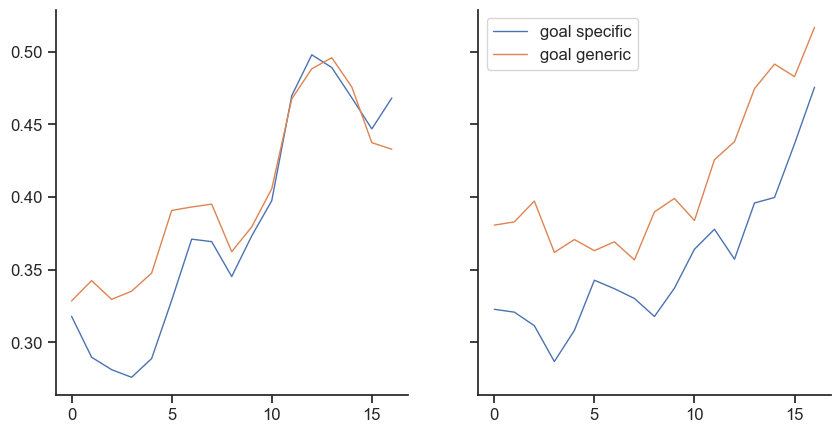

In [116]:
ii = 0

fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)

axes[0].plot(specific_rsquare[0,ii,:,:].mean(axis=0), label='goal specific')
axes[0].plot(generic_rsquare[0,ii,:], label='goal generic')

axes[1].plot(specific_rsquare[1,ii,:,:].mean(axis=0), label='goal specific')
axes[1].plot(generic_rsquare[1,ii,:], label='goal generic')
axes[1].legend()


Text(0, 0.5, 'R² (cond 1)')

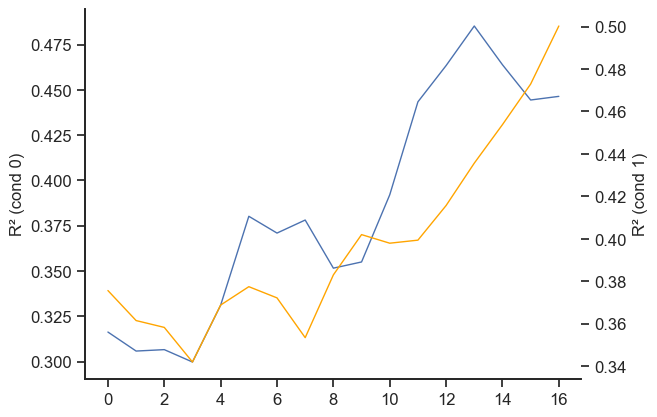

In [56]:
ii = 0

fig, ax = plt.subplots()

ax.plot(rsquare[0, ii, :], label='HPC')
ax.set_ylabel('R² (cond 0)')


ax1 = ax.twinx()
ax1.plot(rsquare[1, ii, :], color='orange', label='OFC')
ax1.set_ylabel('R² (cond 1)')


In [ ]:
predict_value_clf(df, mode, time=np.arange(600,900), lasso_cv=[], fix=0)

In [25]:
# add gaussian noise to FR, see if that changes the mean or variance of value prediction

ses_info = {'session':['031723','032823','033123','032023','040423','040723','050824',  # Bart
               '101124', '100324', '092124', '092324', '092524', '100124','100924'],
           'animal': ['Bart']*7+['London']*7}

all_sessions = pd.DataFrame(ses_info)  # London
all_df = pd.DataFrame()
# rsquare = np.zeros((2,len(all_sessions),17))

for ii in range(1):

    session = all_sessions.iloc[ii].session
    animal = all_sessions.iloc[ii].animal
    print(animal, session)

    DATA_DIR, FIG_DIR = load_data.initiate_directory(animal, session)
    spikes, df, unitNames = load_data.load_beh_neural(animal, session, 'OFC','action_on','trialerror==0')
    pred, ytest = predict_value_add_noise(df.copy(), spikes.copy())
    df['value_pred'] = list(4-pred)
    all_df = pd.concat([all_df,df])

Bart 031723
Building Spike Table


1499it [00:01, 1093.35it/s]


Skipping t=450: Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (45,46) we computed 0.44971585273742676 but the user-supplied value was 0.4497833251953125.
Skipping t=900: Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (45,46) we computed -0.03125572204589844 but the user-supplied value was -0.03130674362182617.
Skipping t=350: Gram matrix passed in via 'precompute' parameter did not pass validation when a single element was checked - please check that it was computed properly. For element (45,46) we computed 0.14049530029296875 but the user-supplied value was 0.14052261412143707.


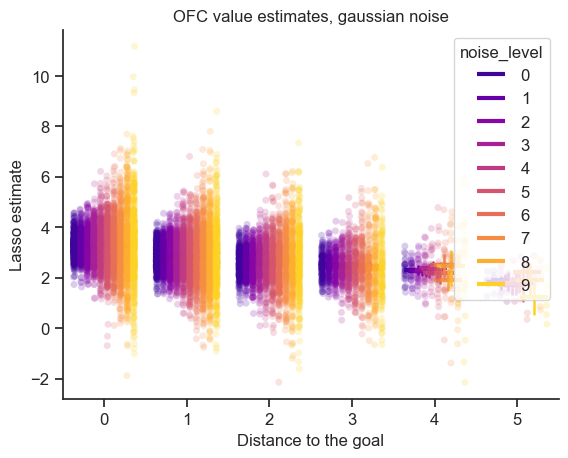

In [33]:
plt.close('all')

dfs = []  # to collect data for each axis

for ii in range(10):
    df_temp = df.copy()
    df_temp['value_pred'] = 4 - pred[:, 16, ii]
    df_temp['noise_level'] = str(ii)   # label each prediction source
    dfs.append(df_temp)

# Combine all into one long dataframe
df_all = pd.concat(dfs, ignore_index=True)

# Drop NaNs (if any)
df_all = df_all.dropna(subset=['graph_distance', 'value_pred'])

# Now you can easily compare across axes

sns.stripplot(
    data=df_all,
    x='graph_distance',
    y='value_pred',
    hue='noise_level',        # <- different axes distinguished by color
    dodge=True, alpha=.2, legend=False, palette='plasma'
)

sns.pointplot(
    data=df_all,
    x='graph_distance',
    y='value_pred',
    hue='noise_level',        # <- different axes distinguished by color
    dodge=.4, linestyle="none", errorbar='ci',
    marker="_", markersize=20, markeredgewidth=3, palette='plasma'
)

plt.ylabel('Lasso estimate')
plt.xlabel('Distance to the goal')
plt.title('OFC value estimates, gaussian noise')
plt.savefig('D:/Figures/OFC value estimates, gaussian noise')


In [11]:
df['length']=[graph.distance(df.start.values[i],df.target.values[i]) for i in range(len(df))]

<Axes: xlabel='nsteps', ylabel='step'>

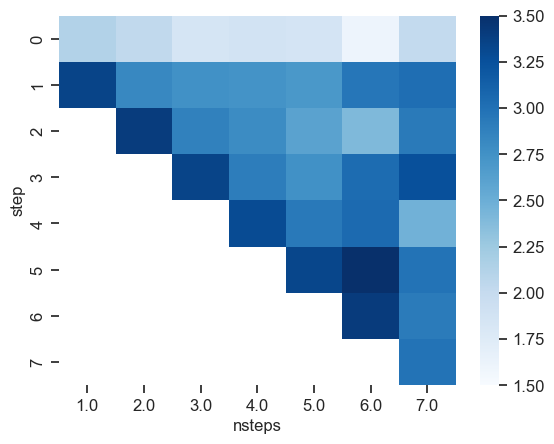

In [213]:
# df['value_pred'] = pred[:,16]
value_heatmap = df.groupby(['step','nsteps'])['value_pred'].mean().reset_index().pivot(index='step', columns='nsteps', values='value_pred')
sns.heatmap(4-value_heatmap,vmin=1.5,vmax=3.5,cmap='Blues')

In [1]:
timestamps = np.arange(100, 950, 50)
plt.close('all')

fig, ax = plt.subplots(figsize=(6, 5))

# --- First group: First step (Blues)
colors1 = sns.color_palette('Blues_r', 4)
first_step_lines = []
for ii in range(4):
    line, = ax.plot(
        timestamps,
        4 - pred[(ytest == ii) & (df.step == 0), :].mean(axis=0),
        color=colors1[ii],
        label=f'Value = {4 - ii}'
    )
    first_step_lines.append(line)

# --- Second group: All steps (Reds)
colors2 = sns.color_palette('Reds_r', 4)
all_steps_lines = []
for ii in range(4):
    line, = ax.plot(
        timestamps,
        4 - pred[(ytest == ii), :].mean(axis=0),
        color=colors2[ii],
        label=f'Value = {4 - ii}'
    )
    all_steps_lines.append(line)

# --- First legend: First step (Blues)
legend1 = ax.legend(handles=first_step_lines, title='First step', loc='lower left')

# --- Second legend: All steps (Reds)
legend2 = ax.legend(handles=all_steps_lines, title='All steps', loc='lower right')

# Important: add the first legend back to the Axes
ax.add_artist(legend1)

# --- Axis labels and limits
ax.set_ylabel('Value estimates')
ax.set_xlabel('Action on')
ax.set_xlim(50, 950)
ax.set_ylim(1, 3.5)

plt.tight_layout()
plt.title('Session %s HPC' % session)
# plt.savefig('D:/Value/Session %s HPC' % session)

NameError: name 'np' is not defined

C:\Users\ML_4\AppData\Local\Temp\ipykernel_24820\2970643304.py:12: RuntimeWarning: Mean of empty slice.
  plt.plot(pred[(ytest==ii)&(df.step==0),:].mean(axis=0),color=colors[ii])
C:\Users\ML_4\anaconda3\Lib\site-packages\numpy\_core\_methods.py:139: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


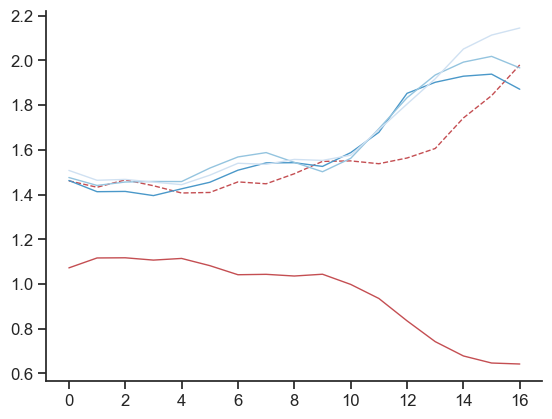

In [178]:
plt.close('all')

target_idx = np.isin(df.node,[1,7,8,14])
reward_idx = df.node==df.target

plt.plot(pred[target_idx & reward_idx,:].mean(axis=0),color='r')
plt.plot(pred[target_idx & ~reward_idx,:].mean(axis=0),color='r',ls='--')


colors=sns.color_palette('Blues_r',4)
for ii in range(4):
    plt.plot(pred[(ytest==ii)&(df.step==0),:].mean(axis=0),color=colors[ii])


In [94]:
r2 = np.zeros(17)
for ii in range(17):
    model = sm.OLS(ytest,add_constant(pred[ii,:])).fit()
    r2[ii]=model.rsquared

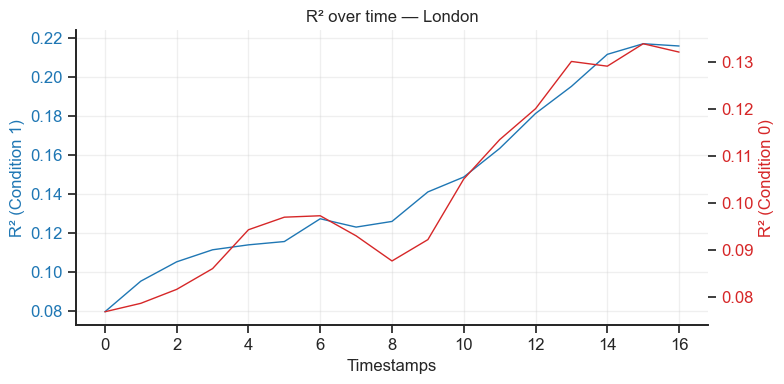

In [106]:
# Calculate your mean traces
y1 = rsquare[1, :7, :].mean(axis=0)
y0 = rsquare[0, :7, :].mean(axis=0)

# Create figure and first axis
fig, ax1 = plt.subplots(figsize=(8, 4))

# Plot first line on left y-axis
ax1.plot(y1, color='tab:blue', label='OFC')
ax1.set_ylabel('R² (Condition 1)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create second axis (sharing the same x-axis)
ax2 = ax1.twinx()
ax2.plot(y0, color='tab:red', label='HPC')
ax2.set_ylabel('R² (Condition 0)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Optional: add x-label and grid
ax1.set_xlabel('Timestamps')
ax1.grid(alpha=0.3)

plt.title("R² over time — London")
plt.tight_layout()
plt.show()


In [84]:
def predict_value(df, FR, ntrials = 1000, w = 100, slide = 50, kfold=10):

    # doing k-fold, looping over all the folds once
    # lasso cv picks the best alpha automatically, better than lasso where alpha is handpicked
    
    timestamps = np.arange(w,1000-w+slide,slide)
    kf = KFold(n_splits=kfold, shuffle=True)
    lasso_cv = LassoCV(cv=5, random_state=42, n_alphas=100)    
    
    FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
         np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)).astype('float32')
    
    df['Neural']=list(FR)
    df.loc[df.graph_distance>2,'graph_distance']=3
    
    train_all = np.zeros((4,kfold,ntrials,FR.shape[1],FR.shape[2]+1))
    test_all = [[] for ii in range(kfold)] # not resampling test trials, so dimensions might be different 
    
    for ii in range(4):
    
        conditioned_beh = df.query('graph_distance==@ii')
        trialNum = np.array(conditioned_beh.index)
        
        for k, (train_ind, test_ind) in enumerate(kf.split(trialNum)):
        
            train_set = conditioned_beh.iloc[train_ind]
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[ii,k,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[ii,k,:,:,-1] = ii
    
            test_temp = np.zeros((len(test_ind),FR.shape[1],FR.shape[2]+1))
            test_set = conditioned_beh.iloc[test_ind]
            test_temp[:,:,:-1] = np.stack(test_set['Neural'].values)
            test_temp[:,:,-1] = ii
            test_all[k].append(test_temp)
    
    pred_value = []
    
    for k in tqdm(range(kfold)):
    
        train_k = train_all[:,k,:,:,:]
        test_k = np.vstack(test_all[k])
        pred_value_temp = np.zeros((len(timestamps),len(test_k)))
        
        for ii,t in enumerate(timestamps): 
        
            train = train_k[:,:,t-w:t+w,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
            lasso_cv.fit(train[:,:-1],train[:,-1])
            
            test = test_k[:,t-w:t+w,:].mean(axis=1)
            pred_value_temp[ii,:] = lasso_cv.predict(test[:,:-1])
            
        pred_value.append(pred_value_temp)

        
    pred_value = np.concat(pred_value,axis=1)
    y_test = np.concat([np.vstack(test_all[k])[:,0,-1] for k in range(len(test_all))])
    rsquare = np.zeros(len(timestamps))
    
    for ii, t in enumerate(timestamps):
        rsquare[ii] = np.corrcoef(pred_value[ii,:],y_test)[0,1]  # actually this is just r, not r square

    return rsquare, lasso_cv

In [ ]:
def value_nav_flash(date,ss):
# split train and test for choice fixations

    ses_df = choice_df.query('Session==@date').copy()
    FR = choice_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    
    balanced_df = (
        ses_df
        .groupby('graph_distance', group_keys=False)
        .apply(lambda x: x.sample(1000, replace=True, random_state=42))
        .reset_index(drop=True)
    )
    
    y = balanced_df['graph_distance'].values   # stratification variable
    X = np.arange(len(y))  # or keep as DataFrame if you prefer
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    train_idx, test_idx = list(skf.split(X, y))[0]
    train_df = balanced_df.iloc[train_idx]
    test_df = balanced_df.iloc[test_idx]
    
    lasso_cv = predict_value_clf(train_df, 'train', lasso_cv=[])
    choice_trained = predict_value_clf(train_df, 'predict', lasso_cv=lasso_cv)
    choice_held_out = predict_value_clf(test_df, 'predict', lasso_cv=lasso_cv)
    nav1 = predict_value_clf(test_df.query('blocktrialnumber==3'), 'predict', lasso_cv=lasso_cv)
    nav2 = predict_value_clf(test_df.query('blocktrialnumber==4'), 'predict', lasso_cv=lasso_cv)
    
    
    # predict values of target nodes in flash trials, action on
    ses_df = flash_df.query('Session==@date').copy()
    FR = flash_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    
    flash1_target = predict_value_clf(ses_df.query('blocktrialnumber==1'), 'predict', lasso_cv=lasso_cv)
    flash2_target = predict_value_clf(ses_df.query('blocktrialnumber==2'), 'predict', lasso_cv=lasso_cv)
    flash1_target = np.concat([flash1_target,ses_df.query('blocktrialnumber==1').pre_distance.values.reshape(1,-1)])
    flash2_target = np.concat([flash2_target,ses_df.query('blocktrialnumber==2').pre_distance.values.reshape(1,-1)])

    # predict values of non-target nodes in flash trials
    ses_df = flash_fix_df.query('Session==@date').copy()
    FR = flash_fix_spikes[ss]
    
    # FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
    #      np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    ses_df['Neural']=list(FR)
    ses_df = ses_df[ses_df.fix_node!=ses_df.target].query('duration>50')
    flash1_nontarget = predict_value_clf(ses_df.query('blocktrialnumber==1'), 'predict', lasso_cv=lasso_cv,fix=1)
    flash2_nontarget = predict_value_clf(ses_df.query('blocktrialnumber==2'), 'predict', lasso_cv=lasso_cv,fix=1)
    flash1_nontarget = np.concat([flash1_nontarget,ses_df.query('blocktrialnumber==1').pre_distance.values.reshape(1,-1)])
    flash2_nontarget = np.concat([flash2_nontarget,ses_df.query('blocktrialnumber==2').pre_distance.values.reshape(1,-1)])
    
    return choice_trained, choice_held_out, np.concatenate([flash1_target,flash1_nontarget],axis=1), np.concatenate([flash2_target,flash2_nontarget],axis=1)

In [21]:
def predict_value_clf(df, mode, time=np.arange(600,900), lasso_cv=[], fix=0):

    if mode == 'train':
        lasso_cv = make_pipeline(
            StandardScaler(),
            LassoCV(cv=5, random_state=42, n_alphas=100)
        )    


    if fix==0:
        timepoints, cell_num = df.iloc[0]['Neural'].shape
        
        data_all = np.concatenate([
            np.stack(df['Neural'].values),
            np.stack(df['graph_distance'].values)[:, None, np.newaxis].repeat(timepoints, axis=1)
        ], axis=2)
        
        data = data_all[:,time,:].mean(axis=1)

    if fix==1:
        data = np.concatenate([
                np.stack(df['Neural'].values),
                np.stack(df['graph_distance'].values).reshape(-1,1)
                ], axis=1)
    
    if mode == 'train':
        lasso_cv.fit(data[:,:-1],data[:,-1])
        return lasso_cv 
        
    if mode == 'predict':
        pred_value = lasso_cv.predict(data[:,:-1])
        return [data[:,-1],pred_value]


In [ ]:
train=[]
test=[]
flash1=[]
flash2=[]

for ss,date in tqdm(enumerate(choice_df.Session.unique())):
    choice_trained, choice_held_out, flash1_value, flash2_value = value_nav_flash(date,ss)
    train.append(choice_trained)
    test.append(choice_held_out)
    flash1.append(flash1_value)
    flash2.append(flash2_value)

In [ ]:
def leave_one_trial_out(df, FR, mode='node', ntrials = 200, w = 100, slide = 50):
    
    # decode single trial dynamics, therefore training the decoder on all the other trials
    timestamps = np.arange(w,1000-w+slide,slide)
    clf = SVC(kernel='linear',probability=True) #LogisticRegression(multi_class='multinomial',random_state=0)
 
    FR = (FR-np.tile(FR.mean(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1)))/ \
         np.tile(FR.std(axis=(0,1),keepdims=True),(FR.shape[0],FR.shape[1],1))
    df['Neural']=list(FR)

    if mode=='node':
        train_all = np.zeros((16,ntrials,FR.shape[1],FR.shape[2]+1))
            
        for node in range(16):
            
            train_set = df[df.node==node]
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[node,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[node,:,:,-1] = node

    if mode=='tele':
        
        train_all = np.zeros((2,ntrials,FR.shape[1],FR.shape[2]+1))
            
        for ii,train_set in enumerate([df[df.node==15],df[df.node!=15]]):
            
            index = np.random.randint(len(train_set),size=ntrials)
            train_all[ii,:,:,:-1] = np.stack(train_set.iloc[index]['Neural'].values)
            train_all[ii,:,:,-1] = ii
    
    train = train_all[:,:,500:800,:].mean(axis=2).reshape(-1,FR.shape[2]+1)
    clf.fit(train[:,:-1],train[:,-1])      
        
    return clf